In [218]:
# Adding the path to the TS_Agent.py file as a system path
import sys  
sys.path.append('../src')
# Importing the .py file with TS agent definition
import TS_Agent as agent_def

# Importing other required libs
import matplotlib.pyplot as plt 
import numpy as np
import random

## Case Study:

### Three battery agent need to make actions for a number of instants out of all available 1440 instants in a day to achieve their respective desired charged states. However, the price paid for charging at each instant of the day is variable, and is unknown to learning agents. Furthermore, it is assumed that no more than 2 battery agents can charge simulataneously to prevent network congestion.

In [219]:
# Initializing an Agent named "Agent 1" that needs 
agent_name = "Agent_1"
resource_required = 300
instants = 1440
alpha = 1

Agent1 = agent_def.TS_Agent(agent_name, resource_required, instants, alpha)

# Initializing an Agent named "Agent 2" that needs 
agent_name = "Agent_2"
resource_required = 280
instants = 1440
alpha = 1

Agent2 = agent_def.TS_Agent(agent_name, resource_required, instants, alpha)

# Initializing an Agent named "Agent 3" that needs 
agent_name = "Agent_3"
resource_required = 320
instants = 1440
alpha = 1

Agent3 = agent_def.TS_Agent(agent_name, resource_required, instants, alpha)

Agent_vector = [Agent1 , Agent2, Agent3]

In [220]:
# Making a variable price curve for the agent's reward. It can be replaced with more realistic electricity price curve as well.
# It should be noted that here reward = price_curve = 1 - electricity price
price_curve = np. concatenate((np.array([1 if (t>100 and t<350) else 0.2 for t in range(0,720)]), np.array([0.9 if (t>100 and t<350) else 0.1 for t in range(0,720)])))

In [221]:
# Number of simulation days
days = 100

In [222]:
# A dictionary of lists for recording agent's observed rewards
observed_rewards = {'1':[],'2':[],'3':[]}


# For each simulation day, the learning agent will make a charging policy. It will then observe rewards equal to instataneous 
# price for each selected charging minute of the simulation day. Agent will update its estimate based on this reward. The 
# Stochastic electricity price is also re-initialized for each day.
for day in range (0,days):
    Agent1.select_actions()
    Agent2.select_actions()
    Agent3.select_actions()
    for minute in range(0,1440):
        # If 3 battery agents are charging simulataneously then 2 agents will be uniformly sampled for 'good' reward. The
        # remaining agent will get the 'bad' reward. If lesser than 3 battery agents are charging simulataneously then all 
        # will get a 'good' reward. Uniform sampling helps in maintaining fairness among agents.
        
        # If system is congested
        if (minute in Agent1.get_selected_actions() and minute in Agent2.get_selected_actions() and minute in Agent3.get_selected_actions()):
            good_reward_agents = random.sample(range(3), 2)
            for a in range(0,3):
                if (a in good_reward_agents):
                    Agent_vector[a].update_estimate(minute,price_curve[minute])
                    observed_rewards[str(a+1)].append(price_curve[minute]) 
                else:
                    Agent_vector[a].update_estimate(minute,0)
                    observed_rewards[str(a+1)].append(0) 
        else: #If system is not congested
            if (minute in Agent1.get_selected_actions()):
                Agent1.update_estimate(minute,price_curve[minute])
                observed_rewards[str(1)].append(price_curve[minute])
            if (minute in Agent2.get_selected_actions()):
                Agent2.update_estimate(minute,price_curve[minute])
                observed_rewards[str(2)].append(price_curve[minute])
            if (minute in Agent3.get_selected_actions()):
                Agent3.update_estimate(minute,price_curve[minute])
                observed_rewards[str(3)].append(price_curve[minute])

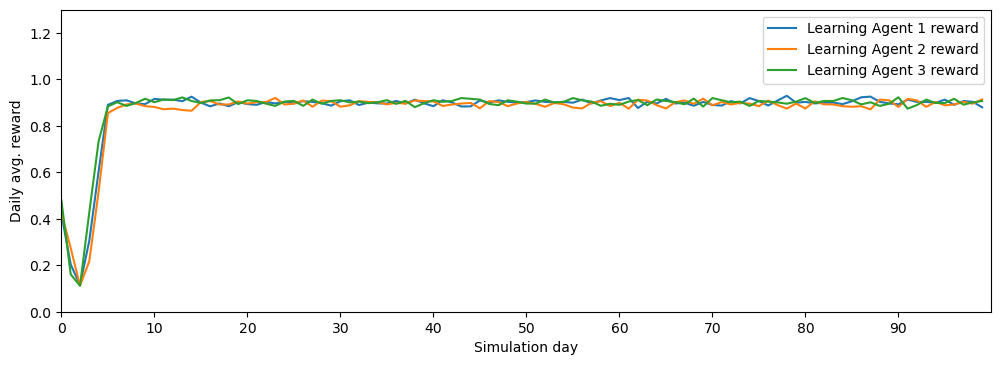

In [224]:
# Plotting average daily reward observed by the learning agent
plt.figure(figsize=(12,4), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(np.average(np.array(observed_rewards['1']).reshape(-1, Agent_vector[0].get_resource_required()), axis=1))
plt.plot(np.average(np.array(observed_rewards['2']).reshape(-1, Agent_vector[1].get_resource_required()), axis=1))
plt.plot(np.average(np.array(observed_rewards['3']).reshape(-1, Agent_vector[2].get_resource_required()), axis=1))
plt.xlabel('Simulation day')
plt.ylabel('Daily avg. reward')
plt.legend(["Learning Agent 1 reward", "Learning Agent 2 reward","Learning Agent 3 reward"])
plt.xlim(0,days)
plt.ylim(0,1.3)
plt.xticks([i for i in range(0,days,10)]);